In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from transformers import pipeline

warnings.filterwarnings("ignore")
%load_ext jupyter_black

In [2]:
df = pd.read_csv("../data/The-Office-Lines-V4.csv")
df.head()

,season,episode,title,scene,speaker,line,Unnamed: 6
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...,NaN
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So...",NaN
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...,NaN
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah.",NaN
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done.",NaN


In [3]:
print(df.columns)
print(df.info())

Index(['season', 'episode', 'title', 'scene', 'speaker', 'line', 'Unnamed: 6'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54626 entries, 0 to 54625
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   season      54626 non-null  int64 
 1   episode     54626 non-null  int64 
 2   title       54626 non-null  object
 3   scene       54626 non-null  int64 
 4   speaker     54626 non-null  object
 5   line        54626 non-null  object
 6   Unnamed: 6  17 non-null     object
dtypes: int64(3), object(4)
memory usage: 2.9+ MB
None


In [4]:
df = df[["season", "episode", "title", "scene", "speaker", "line"]]
df.head()

,season,episode,title,scene,speaker,line
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So..."
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah."
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done."


In [5]:
print(df.line[0])

All right Jim. Your quarterlies look very good. How are things at the library?


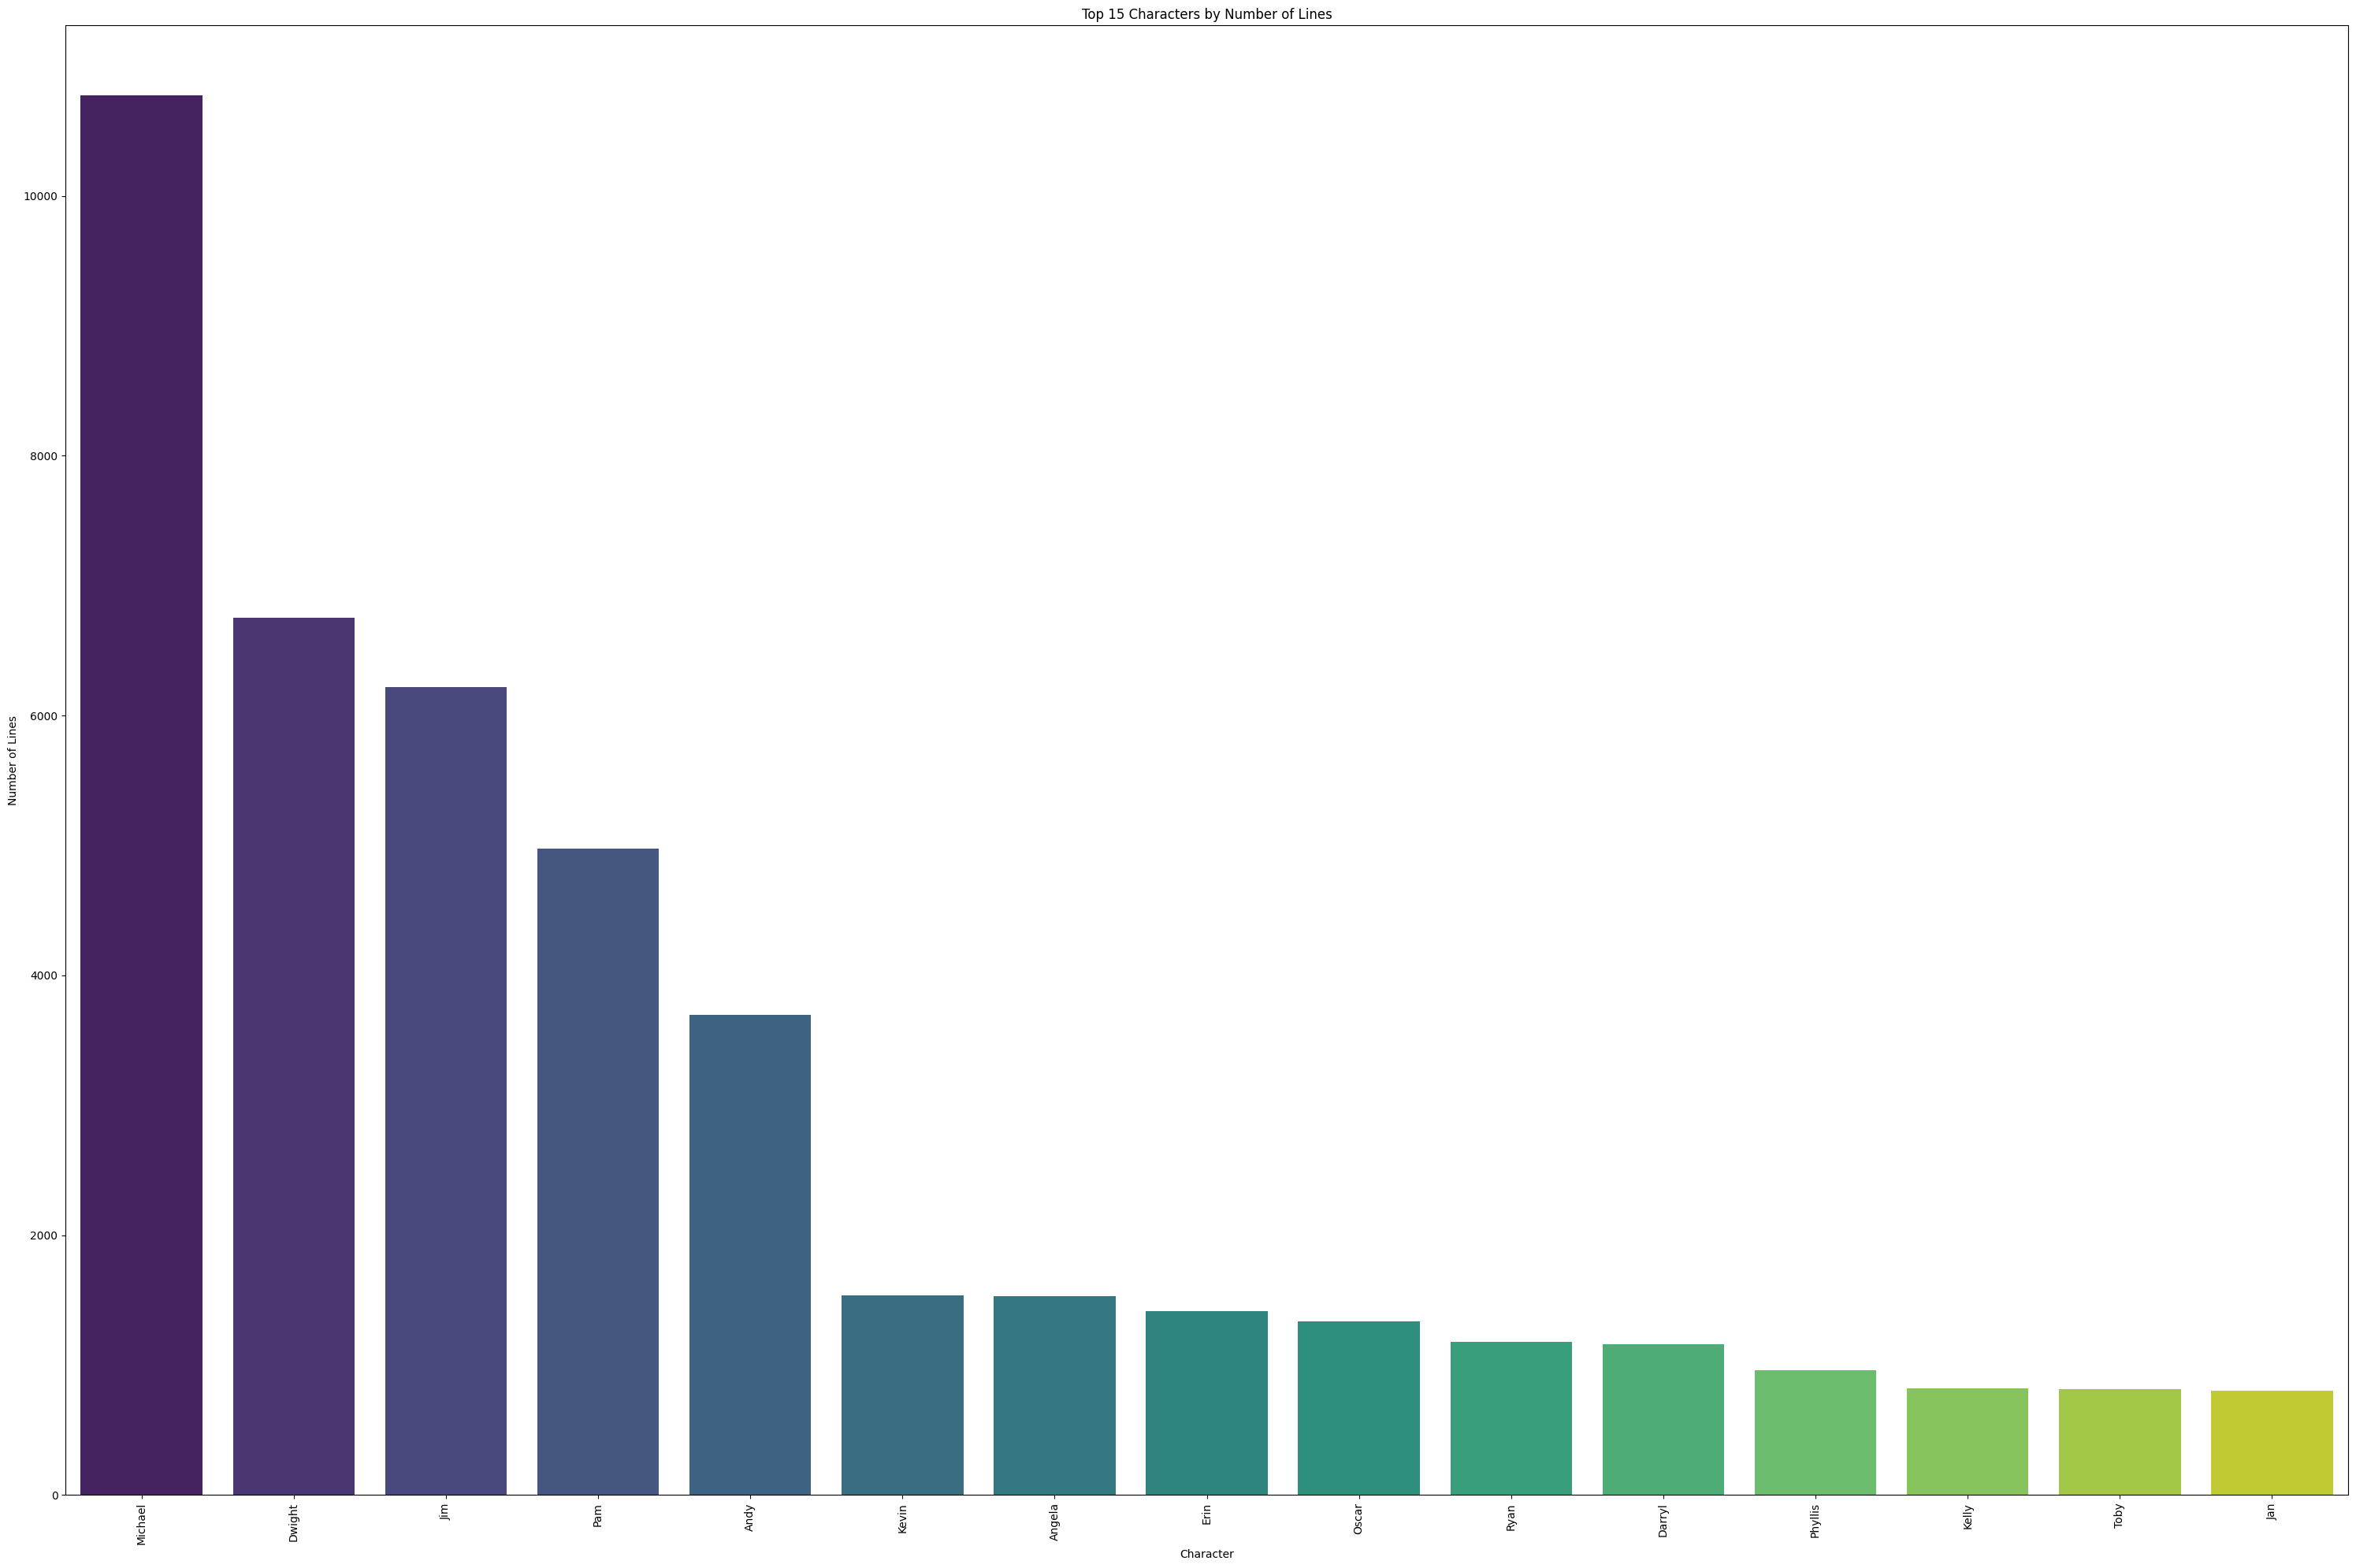

In [6]:
speaker_counts = df["speaker"].value_counts().reset_index()
speaker_counts.columns = ["speaker", "line_count"]

plt.figure(figsize=(30, 20))
sns.barplot(
    data=speaker_counts.head(15), x="speaker", y="line_count", palette="viridis"
)
plt.xticks(rotation=90)
plt.title("Top 15 Characters by Number of Lines")
plt.xlabel("Character")
plt.ylabel("Number of Lines")
plt.tight_layout()
plt.show()

In [7]:
pip install torch


Note: you may need to restart the kernel to use updated packages.


In [8]:
from transformers import pipeline
import torch

emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=True,
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

In [9]:
def get_top_emotions(text, top_k=2):
    scores = emotion_classifier(text)[0]
    sorted_scores = sorted(scores, key=lambda x: x["score"], reverse=True)
    return [e["label"] for e in sorted_scores[:top_k]]

In [10]:
df["emotions"] = df["line"].apply(get_top_emotions)

In [11]:
print(df.head(10))

   season  episode  title  scene  speaker  \
0       1        1  Pilot      1  Michael   
1       1        1  Pilot      1      Jim   
2       1        1  Pilot      1  Michael   
3       1        1  Pilot      1      Jim   
4       1        1  Pilot      1  Michael   
5       1        1  Pilot      2  Michael   
6       1        1  Pilot      3  Michael   
7       1        1  Pilot      3      Pam   
8       1        1  Pilot      3  Michael   
9       1        1  Pilot      3      Pam   

                                                line             emotions  
0  All right Jim. Your quarterlies look very good...       [neutral, joy]  
1         Oh, I told you. I couldn't close it. So...   [sadness, neutral]  
2  So you've come to the master for guidance? Is ...  [neutral, surprise]  
3         Actually, you called me in here, but yeah.   [neutral, sadness]  
4    All right. Well, let me show you how it's done.     [neutral, anger]  
5   Yes, I'd like to speak to your office manage

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import string

# Load the sarcasm model
MODEL_PATH = "helinivan/english-sarcasm-detector"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)


def preprocess_data(text: str) -> str:
    return text.lower().translate(str.maketrans("", "", string.punctuation)).strip()


def detect_sarcasm(text, threshold=0.5):
    tokenized_text = tokenizer(
        [preprocess_data(text)],
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt",
    )
    with torch.no_grad():
        output = model(**tokenized_text)
    probs = output.logits.softmax(dim=-1).tolist()[0]
    confidence = max(probs)
    prediction = probs.index(confidence)
    is_sarcastic = bool(prediction)  # Usually 1 = sarcastic, 0 = not
    return "sarcastic" if is_sarcastic and confidence >= threshold else "not_sarcastic"

tokenizer_config.json:   0%|          | 0.00/400 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [13]:
df["sarcasm"] = df["line"].apply(detect_sarcasm)

In [18]:
df.head(20)

,season,episode,title,scene,speaker,line,emotions,sarcasm
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...,"[neutral, joy]",not_sarcastic
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So...","[sadness, neutral]",not_sarcastic
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...,"[neutral, surprise]",not_sarcastic
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah.","[neutral, sadness]",sarcastic
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done.","[neutral, anger]",not_sarcastic
5,1,1,Pilot,2,Michael,"Yes, I'd like to speak to your office manager...","[neutral, sadness]",sarcastic
6,1,1,Pilot,3,Michael,"I've, uh, I've been at Dunder Mifflin for 12 y...","[neutral, surprise]",not_sarcastic
7,1,1,Pilot,3,Pam,Well. I don't know.,"[surprise, neutral]",not_sarcastic
8,1,1,Pilot,3,Michael,"If you think she's cute now, you should have s...","[neutral, disgust]",not_sarcastic
9,1,1,Pilot,3,Pam,What?,"[surprise, anger]",not_sarcastic


Text(0.5, 1.0, 'Sarcasm Detection Results')

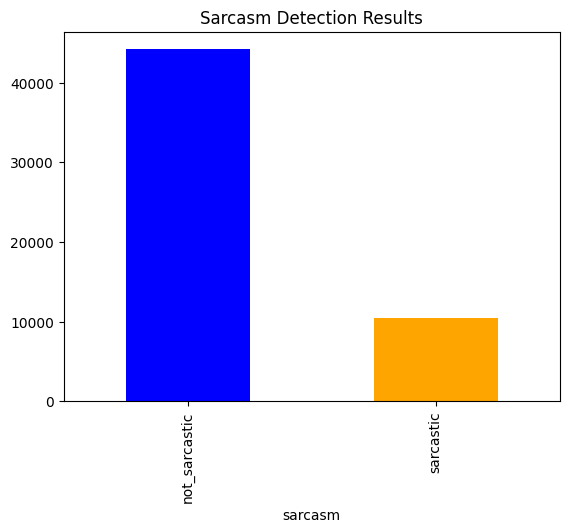

In [17]:
df.sarcasm.value_counts().plot(kind="bar", color=["blue", "orange"])
plt.title("Sarcasm Detection Results")